# Introduction

This notebook implements DDPM from the paper https://arxiv.org/abs/2006.11239.

It is based on the original implementation by the author: https://github.com/hojonathanho/diffusion and on the pytorch implementation by Phil Wang: https://github.com/lucidrains/denoising-diffusion-pytorch.

Trained on the Flowers102 dataset: https://www.robots.ox.ac.uk/~vgg/data/flowers/102/.

In [ ]:
!pip install einops matplotlib scipy tqdm imageio tensorflow_docs

In [27]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from einops import rearrange
from torch import nn, einsum

%matplotlib inline

# Model architecture

#### Sinusoidal Position Embeddings

In [3]:
class PositionEmbeddings(nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.dim = dim

  def forward(self, timestamps):
    # Based on fairseq implementation:
    # https://github.com/facebookresearch/fairseq/blob/main/fairseq/modules/sinusoidal_positional_embedding.py
    device = timestamps.device
    half_dim = self.dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
    emb = timestamps[:, None] * emb[None, :]
    emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
    return emb

#### Group Normalization

In [4]:
groups = 8

In [5]:
def normalize(num_channels, num_groups=groups):
  return nn.GroupNorm(num_groups=num_groups, num_channels=num_channels)

#### Swish (aka SiLU) nonlinearity activation function

In [6]:
def swish(inplace=False):
  return torch.nn.SiLU(inplace=inplace)

#### Time Embedding layer

In [7]:
class TimeMLP(nn.Module):
  def __init__(self, in_dim, out_dim):
    super().__init__()
    self.pos_emb = PositionEmbeddings(in_dim)
    self.linear1 = nn.Linear(in_dim, out_dim)
    self.linear2 = nn.Linear(out_dim, out_dim)
    self.act = swish()

  def forward(self, x):
    temb = self.pos_emb(x)
    temb = self.linear1(temb)
    temb = self.act(temb)
    temb = self.linear2(temb)
    return temb

#### Upsample block

In [8]:
class UpsampleBlock(nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.upsample = nn.Upsample(scale_factor=2.0, mode='nearest')
    self.conv = nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding='same')

  def forward(self, x):
    B, C, H, W = x.shape

    x = self.upsample(x)
    x = self.conv(x)
    assert x.shape == (B, C, H*2, W*2)

    return x

#### Downsample block

In [9]:
class DownsampleBlock(nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.conv = nn.Conv2d(dim, dim, kernel_size=3, stride=2, padding=1)

  def forward(self, x):
    B, C, H, W = x.shape

    x = self.conv(x)
    assert x.shape == (B, C, H // 2, W // 2)

    return x

#### ResNet block

In [10]:
class ResNetBlock(nn.Module):
  def __init__(self, dim_in, dim_out, time_emb_dim, num_groups=groups):
    super().__init__()
    self.act = swish()

    self.norm1 = normalize(num_groups=num_groups, num_channels=dim_in)
    self.conv1 = nn.Conv2d(dim_in, dim_out, kernel_size=3, stride=1, padding='same')

    self.norm2 = normalize(num_groups=num_groups, num_channels=dim_out)
    self.conv2 = nn.Conv2d(dim_out, dim_out, kernel_size=3, stride=1, padding='same')

    self.linear = nn.Linear(time_emb_dim, dim_out)
    self.dim_out = dim_out
    self.conv_match = nn.Conv2d(dim_in, dim_out, kernel_size=1)

  def forward(self, x, temb):
    # normalize -> nonlinearity -> conv
    h = x
    h = self.norm1(h)
    h = self.act(h)
    h = self.conv1(h)

    # makes sure x shape will match with h shape
    if x.shape[1] != self.dim_out:
      x = self.conv_match(x)

    # add timestep embedding
    timestep_emb = self.act(temb)
    timestep_emb = self.linear(timestep_emb)
    timestep_emb = timestep_emb[:, :, None, None] # B, C, 1, 1

    h = h + timestep_emb

    # normalize -> nonlinearity -> conv
    h = self.norm2(h)
    h = self.act(h)
    h = self.conv2(h)
    assert h.shape == x.shape

    # add residual
    h = h + x
    return h

#### Attention blocks

In [11]:
# From Phil Wang's implementation
class Attention(nn.Module):
  def __init__(self, dim, heads=4, dim_head=32):
    super().__init__()
    self.scale = dim_head**-0.5
    self.heads = heads

    hidden_dim = dim_head * heads
    self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
    self.conv = nn.Conv2d(hidden_dim, dim, 1)

  def forward(self, x):
    B, C, H, W = x.shape

    qkv = self.to_qkv(x).chunk(3, dim=1)
    q, k, v = map(lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv)

    # Attention = softmax(Q*K_T / sqrt(d_k))*V
    # qxk = einsum("b h d i, b h d j -> b h i j", q, k)
    qxk = einsum("b h d i, b h d j -> b h i j", q, k)
    qxk = qxk * self.scale
    qxk = qxk - qxk.amax(dim=-1, keepdim=True).detach()
    att = qxk.softmax(dim=-1)

    att = einsum("b h i j, b h d j -> b h i d", att, v)
    att = rearrange(att, "b h (x y) d -> b (h d) x y", x=H, y=W)
    return self.conv(att)

class LinearAttention(nn.Module):
  def __init__(self, dim, heads=4, dim_head=32):
    super().__init__()
    self.scale = dim_head**-0.5
    self.heads = heads

    hidden_dim = dim_head * heads
    self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

    self.conv = nn.Conv2d(hidden_dim, dim, 1)
    self.norm = normalize(num_channels=dim)

  def forward(self, x):
    B, C, H, W = x.shape

    qkv = self.to_qkv(x).chunk(3, dim=1)
    q, k, v = map(lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv)

    q = q.softmax(dim=-2)
    k = k.softmax(dim=-1)

    q = q * self.scale
    context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

    att = torch.einsum("b h d e, b h d n -> b h e n", context, q)
    att = rearrange(att, "b h c (x y) -> b (h c) x y", h=self.heads, x=H, y=W)
    att = self.conv(att)
    att = self.norm(att)
    return att

#### U-Net model

In [12]:
class UNet(nn.Module):
  def __init__(self,
               in_dim,
               widths,
               channels=3,
               add_attention=[False, False, True, True]):
    super().__init__()

    in_dims = [in_dim] + widths[:-1]
    out_dims = widths

    # Initial convolution
    self.first_conv = nn.Conv2d(channels, in_dim, kernel_size=3, padding='same')

    # Timestep embedding
    self.time_mlp = TimeMLP(in_dim, in_dim * 4)
    time_dim = in_dim * 4

    # Downsampling
    self.downs = nn.ModuleList([])
    for i in range(len(widths)):
      self.downs.append(
          nn.ModuleList([
              ResNetBlock(in_dims[i], in_dims[i], time_emb_dim=time_dim),
              ResNetBlock(in_dims[i], out_dims[i], time_emb_dim=time_dim),
              LinearAttention(out_dims[i]) if add_attention[i] else nn.Identity(),
              DownsampleBlock(out_dims[i]) if out_dims[i] != out_dims[-1] else nn.Identity()
          ])
      )

    # Middle
    self.middle_block1 = ResNetBlock(out_dims[-1], out_dims[-1], time_emb_dim=time_dim)
    self.middle_attn = Attention(out_dims[-1])
    self.middle_block2 = ResNetBlock(out_dims[-1], out_dims[-1], time_emb_dim=time_dim)

    # Upsampling
    self.ups = nn.ModuleList([])
    for i in reversed(range(len(widths))):
      self.ups.append(
          nn.ModuleList([
              ResNetBlock(out_dims[i] * 2, out_dims[i] * 2, time_emb_dim=time_dim),
              ResNetBlock(out_dims[i] * 2, in_dims[i], time_emb_dim=time_dim),
              LinearAttention(in_dims[i]) if add_attention[i] else nn.Identity(),
              UpsampleBlock(in_dims[i]) if i != 0 else nn.Identity()
          ])
      )

    # Final layer
    self.final_norm = normalize(num_channels=in_dims[0])
    self.final_act = swish()
    self.final_conv = nn.Conv2d(in_dim, channels, 1)

  def forward(self, x, t):
    x = self.first_conv(x)

    # Timestep embedding
    t = self.time_mlp(t)
    hs = []

    # Downsampling
    for block1, block2, attn, down_sample in self.downs:
      x = block1(x, t)
      x = block2(x, t)
      x = attn(x)
      hs.append(x)
      x = down_sample(x)

    # Middle
    x = self.middle_block1(x, t)
    x = self.middle_attn(x)
    x = self.middle_block2(x, t)

    # Upsampling
    for block1, block2, attn, up_sample in self.ups:
      x = torch.cat((x, hs.pop()), dim=1)
      x = block1(x, t)
      x = block2(x, t)
      x = attn(x)
      x = up_sample(x)

    # Last layer
    x = self.final_norm(x)
    x = self.final_act(x)
    x = self.final_conv(x)
    return x

# Diffusion utilities

In [13]:
beta_1 = 1e-4
beta_T = 0.02
timesteps = 1000

betas = torch.linspace(beta_1, beta_T, timesteps)

In [14]:
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

In [15]:
# diffusion: q(x_t | x_{t-1})
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / alphas_cumprod)
sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / alphas_cumprod - 1)

# posterior: q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)

In [16]:
"""
Extract coefficients at specified timesteps,
then reshape to [batch_size, 1, 1, 1, 1, ...] for broadcasting purposes.
"""
def extract(a, t, x_shape):
  batch_size = t.shape[0]
  out = a.gather(-1, t.cpu())
  return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [17]:
# forward process, add noise
def q_sample(x_start, t, noise=None):
  if noise is None:
    noise = torch.randn_like(x_start)

  return extract(sqrt_alphas_cumprod, t, x_start.shape) * x_start + \
         extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise

In [18]:
def p_losses(model, x_start, t, noise=None):
  if noise is None:
    noise = torch.randn_like(x_start)

  x_noisy = q_sample(x_start, t, noise)
  pred_noise = model(x_noisy, t)

  # MSE loss
  #loss = F.mse_loss(noise, pred_noise)

  # huber loss
  loss = F.smooth_l1_loss(noise, pred_noise)

  return loss

In [19]:
# reverse process
def p_sample(model, x, t, t_index):
  betas_t = extract(betas, t, x.shape)
  sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
  sqrt_one_minus_alphas_cumprod_t = extract(
      sqrt_one_minus_alphas_cumprod, t, x.shape
  )

  pred_noise = model(x, t)
  # Equation 11 from paper
  model_mean = sqrt_recip_alphas_t * (
      x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t
  )

  if t_index == 0:
    return model_mean

  posterior_variance_t = extract(posterior_variance, t, x.shape)
  noise = torch.randn_like(x)
  return model_mean + torch.sqrt(posterior_variance_t) * noise

# Data

In [20]:
BATCH_SIZE = 32
NUM_WORKERS = 2
image_size = 64

In [21]:
from torchvision.transforms.functional import crop

def crop_and_scale_image(img):
  C, H, W = img.shape

  new_size = min(H, W)

  top = (H - new_size) // 2
  left = (W - new_size) // 2
  height = new_size
  width = new_size

  # change pixel values to range [-1.0, 1.0]
  img = (img * 2.0) - 1.0
  img = torch.clip(img, min=-1.0, max=1.0)

  return crop(img, top, left, height, width)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(crop_and_scale_image),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize([image_size, image_size]),
    transforms.RandomHorizontalFlip(),
])

data = torchvision.datasets.Flowers102(root='./data',
                                             split='train',
                                             download=True,
                                             transform=transform)
data_loader = torch.utils.data.DataLoader(data,
                                          batch_size=BATCH_SIZE,
                                          #num_workers=NUM_WORKERS,
                                          shuffle=True)

In [23]:
print(len(data))

1020


In [24]:
def convert_image(img):
  # when applying normalize
  #min = img.min()
  #max = img.max()
  #img = (img - min) / (max - min)

  # when applying scale
  img = (img + 1.0) / 2.0
  img = torch.clip(img, min=0.0, max=1.0)

  img = np.transpose(img, (1, 2, 0))
  return img

In [33]:
data_samples = []
N = 25
random_indices = random.sample(list(range(len(data))), N)

for i in range(N):
  index = random_indices[i]
  data_samples.append(data.__getitem__(index))

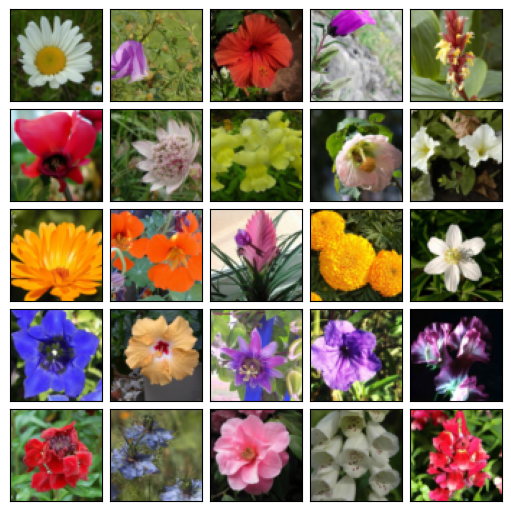

In [34]:
fig, axs = plt.subplots(figsize=(5, 5), layout='constrained')
axs.set_axis_off()

for i in range(N):
  fig.add_subplot(5, 5, i+1)

  temp = data_samples[i]
  image = convert_image(temp[0])

  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

plt.show()

# Training

In [35]:
from torch.optim import Adam

In [36]:
EPOCHS = 1600
lr = 8e-5
first_channels = 64
channel_mult = (1, 2, 4, 8)
input_channels = 3

widths = [first_channels * mult for mult in channel_mult]
add_attention=[False, False, True, True]

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
model = UNet(
    in_dim=image_size,
    widths=widths,
    channels=input_channels,
    add_attention=add_attention
)

model.to(device)

In [39]:
optimizer = Adam(model.parameters(), lr=lr)

In [40]:
from tqdm import tqdm

In [41]:
def train(model, optimizer, epochs, data_loader):
  model.train()
  for epoch in range(epochs):
    curr_loss = 0

    #for step, batch in enumerate(tqdm(data_loader)):
    for step, batch in enumerate(data_loader):
      optimizer.zero_grad()

      batch_size = len(batch[0])
      images = batch[0].to(device)
      # labels = batch[1].to(device)

      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      loss = p_losses(model, images, t)
      curr_loss += loss.item()

      loss.backward()
      optimizer.step()

    if (epoch + 1) % 10 == 0:
      print(f"Epoch: {epoch+1} | loss: {curr_loss}")

In [ ]:
train(model, optimizer, EPOCHS, data_loader)

# Results

In [50]:
file_path = "./images"

In [52]:
@torch.no_grad()
def p_sample_loop(model, shape, timesteps):
  device = next(model.parameters()).device

  B = shape[0]

  img = torch.randn(shape, device=device)
  imgs = []

  for i in reversed(range(0, timesteps)):
    img = p_sample(model, img, torch.full((B,), i, device=device, dtype=torch.long), i)
    imgs.append(img.cpu().numpy())

  return imgs

In [53]:
@torch.no_grad()
def sample(model, image_size, batch_size, channels, timesteps):
  return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size), timesteps=timesteps)

In [54]:
sample_batch_size = 64

In [55]:
samples = sample(model, image_size=image_size, batch_size=sample_batch_size, channels=input_channels, timesteps=timesteps)

In [56]:
cols = 5
rows = 3

indices = random.sample(list(range(sample_batch_size)), cols*rows)

for i in range(0, timesteps):
  if (i + 1) % 20 == 0:
    fig = plt.figure(figsize=(cols, rows), layout='constrained')

    # Create grid of images
    for j in range(cols*rows):
      plt.subplot(rows, cols, j+1)

      index = indices[j]
      img = torch.from_numpy(samples[i][index])
      img = convert_image(img)
      plt.imshow(img, animated=True)
      plt.xticks([])
      plt.yticks([])
      plt.axis('off')

    plt.savefig(file_path + 'image_at_timestep_{:04d}.png'.format(i))

    plt.close()

plt.show()

In [57]:
import glob
import imageio

In [ ]:
anim_file = 'ddpm.gif'

filenames = glob.glob(file_path + 'image*.png')
filenames = sorted(filenames)
images = []

with imageio.get_writer(file_path + anim_file, mode='I') as writer:
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)

  image = imageio.imread(filename)
  writer.append_data(image)

In [59]:
import tensorflow_docs.vis.embed as embed

In [ ]:
embed.embed_file(file_path + anim_file)